In [101]:
import math
import numpy as np
import matplotlib.pyplot as plt



Derive the attinuation parameter 

In [102]:
data = [
    (90, 200, 5.22),
]
pitch = 0.813 

results = []
for kVp, mAs, ctdi in data:
    volt = kVp
    denom = (volt**2 * mAs) / pitch
    C = ctdi / denom
    results.append((kVp, mAs, C))

C_vals = np.array([r[2] for r in results])

A = C_vals.mean()
print(f"A = {A}")



A = 2.6196666666666667e-06


Derive the scaling factor

In [149]:
data = [
    (90, 200, 7.26),
]

time = 1                 # seconds
slice = 0.0025               # meters (slice thickness)

def mew(e):
    return (0.4259 * e)**(-0.696)

k_vals = []

for kVp, mAs, snr in data:
    energy_mean = kVp/2.5              # keV
    mu = mew(energy_mean)
    current = mAs
    SNR = snr
    
    k = (SNR**2 * energy_mean) / ( (kVp**2) * current * math.exp(-mu * slice) * time )
    k_vals.append((kVp, mAs, k))

k_only = np.array([row[2] for row in k_vals])
k = k_only.mean()
print(f"k = {k}")


k = 0.0011717180233598735


Objective functions

In [150]:

def snr_formula(k, V, I, t, e_mean, x):
    # returns SNR (note: uses e_mean in same units as provided)
    mu = mew(e_mean)
    return np.sqrt((k * (V**2) * I * np.exp(-mu * x) * t) / e_mean)

def ctdi_formula(A, V, I, t, P):
    # returns CTDI
    return A * V * V * I * t * (1.0 / P)

Ranges of accepted values

In [151]:

bounds = {
    "I": (10, 640),             # mA
    "V": (80.0, 140.0),         # kV
    "P": (0.5, 1.5),            # pitch
    "t": (0.5, 1),               # seconds
    "x": (0.625e-3, 10e-3),     # meters
    "e_mean": (35.0, 70.0)      # keV
}

Create 20000 random samples of teh variabels within their ranges

In [ ]:
n_samples = 20000  # sampling resolution
n_weights = 101    # number of weights in [0,1] to sweep

rng = np.random.default_rng(0)

def sample_design_space(n):
    # each variable sampled uniformly within bounds
    I = rng.uniform(bounds["I"][0], bounds["I"][1], size=n)
    V = rng.uniform(bounds["V"][0], bounds["V"][1], size=n)
    P = rng.uniform(bounds["P"][0], bounds["P"][1], size=n)
    t = rng.uniform(bounds["t"][0], bounds["t"][1], size=n)
    x = rng.uniform(bounds["x"][0], bounds["x"][1], size=n)
    e_mean = rng.uniform(bounds["e_mean"][0], bounds["e_mean"][1], size=n)
    return I, V, P, t, x, e_mean


# compute samples and objectives
I_s, V_s, P_s, t_s, x_s, e_mean_s = sample_design_space(n_samples)

snr_vals = snr_formula(k, V_s, I_s, t_s, e_mean_s, x_s)
ctdi_vals = ctdi_formula(A, V_s, I_s, t_s, P_s)

20000


Find the min and max of each objective function seperately

In [153]:
snr_min, snr_max = float(np.min(snr_vals)), float(np.max(snr_vals))
ctdi_min, ctdi_max = float(np.min(ctdi_vals)), float(np.max(ctdi_vals))

print(f"Sampled SNR range: min={snr_min:.6g}, max={snr_max:.6g}")
print(f"Sampled CTDI range: min={ctdi_min:.6g}, max={ctdi_max:.6g}")

Sampled SNR range: min=0.931894, max=18.6531
Sampled CTDI range: min=0.0967927, max=54.1367


This is covered by the sampling, but just computes the ideal min values of each function. Effectively, it gets the max SNR and min CTDI

In [154]:
# --- Find ideal solution f* by independent optimization via sampled points ---
# For SNR (maximize)
idx_max_snr = np.argmax(snr_vals)
fstar_snr = snr_vals[idx_max_snr]
design_fstar_snr = {
    "I": I_s[idx_max_snr], "V": V_s[idx_max_snr], "P": P_s[idx_max_snr],
    "t": t_s[idx_max_snr], "x": x_s[idx_max_snr], "e_mean": e_mean_s[idx_max_snr]
}

# For CTDI (minimize)
idx_min_ctdi = np.argmin(ctdi_vals)
fstar_ctdi = ctdi_vals[idx_min_ctdi]
design_fstar_ctdi = {
    "I": I_s[idx_min_ctdi], "V": V_s[idx_min_ctdi], "P": P_s[idx_min_ctdi],
    "t": t_s[idx_min_ctdi], "x": x_s[idx_min_ctdi], "e_mean": e_mean_s[idx_min_ctdi]
}

print("\nIdeal (sampled) solutions f*:")
print(f" - f*_SNR  = {fstar_snr:.6g} at sample index {idx_max_snr}")
print(f" - f*_CTDI = {fstar_ctdi:.6g} at sample index {idx_min_ctdi}")


Ideal (sampled) solutions f*:
 - f*_SNR  = 18.6531 at sample index 17755
 - f*_CTDI = 0.0967927 at sample index 4077


For SNR:
distance is how much worse the sample is than the best SNR found

For CTDI:
distance is how much worse the sample is than the best CTDI found

Distances are normalized so that both objectives are scaled comparably.

In [155]:
# normalize denominators (avoid zero division)
snr_range = snr_max - snr_min if (snr_max - snr_min) > 0 else 1.0
ctdi_range = ctdi_max - ctdi_min if (ctdi_max - ctdi_min) > 0 else 1.0

# For SNR, ideal is fstar_snr (max). We use normalized differences measured from ideal.
# d_snr = (f*_SNR - snr) / (snr_max - snr_min)  -> 0 when snr == ideal (max)
# For CTDI, ideal is fstar_ctdi (min):
# d_ctdi = (ctdi - f*_CTDI) / (ctdi_max - ctdi_min) -> 0 when ctdi == ideal (min)
d_snr = (fstar_snr - snr_vals) / snr_range
d_ctdi = (ctdi_vals - fstar_ctdi) / ctdi_range

For each weight value:
- Compute the weighted distance for every sampled solution
- Pick the solution that has the smallest distance
- Store it

In [162]:
# --- Euclidean Weighted Matrix sweep over weights ---
weights = np.linspace(0, 1, n_weights)
selected_indices = []
selected_info = []

for w in weights:
    # weighted Euclidean distance (two objectives)
    dist = np.sqrt(w * (d_snr ** 2) + (1 - w) * (d_ctdi ** 2))
    idx = int(np.argmin(dist))
    if idx not in selected_indices:
        selected_indices.append(idx)
        selected_info.append({
            "weight": float(w),
            "index": idx,
            "I": float(I_s[idx]), "V": float(V_s[idx]), "P": float(P_s[idx]),
            "t": float(t_s[idx]), "x": float(x_s[idx]), "e_mean": float(e_mean_s[idx]),
            "snr": float(snr_vals[idx]), "ctdi": float(ctdi_vals[idx])
        })

print(f"\nNumber of unique solutions found by EWM weight sweep: {len(selected_info)}", "selected info", selected_info)


Number of unique solutions found by EWM weight sweep: 17 selected info [{'weight': 0.0, 'index': 4077, 'I': 10.724792083853544, 'V': 80.1698495812784, 'P': 1.1435795113523155, 't': 0.6129876627052794, 'x': 0.0019504810288394365, 'e_mean': 39.18247517665824, 'snr': 1.1239248662713455, 'ctdi': 0.09679265909642758}, {'weight': 0.01, 'index': 16947, 'I': 154.30672352382817, 'V': 118.1200475551786, 'P': 1.4983119518591175, 't': 0.5674954678012873, 'x': 0.005891908746479955, 'e_mean': 35.3333091476512, 'snr': 6.362426535494697, 'ctdi': 2.1361820611594435}, {'weight': 0.02, 'index': 4454, 'I': 373.874879746389, 'V': 82.61699250202432, 'P': 1.4639491091222854, 't': 0.6380437625758786, 'x': 0.003865789688502327, 'e_mean': 35.202579527064366, 'snr': 7.359605734973483, 'ctdi': 2.9136378537895253}, {'weight': 0.03, 'index': 11850, 'I': 183.75350176571052, 'V': 112.06374922086908, 'P': 1.4673125577316042, 't': 0.8934185513725477, 'x': 0.00462558115901961, 'e_mean': 35.17889190935279, 'snr': 8.2837

Using nondominated sorting:

A solution A dominates solution B if:

A has ≥ SNR than B, and

A has ≤ CTDI than B, and

at least one is strict (better)

All solutions that are not dominated by any other form the Pareto front.

This gives an independent check of the multi-objective result.

In [168]:
# --- compute approximate Pareto front via nondominated sorting ---
def nondominated_sort(snr, ctdi):
    n = len(snr)
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not is_pareto[i]:
            continue

        # Compare to all other points
        for j in range(n):
            if i == j:
                continue

            # Check if j dominates i
            if ((snr[j] >= snr[i]) and
                (ctdi[j] <= ctdi[i]) and
                ((snr[j] > snr[i]) or (ctdi[j] < ctdi[i]))):
                is_pareto[i] = False
                break

    return is_pareto


pareto_mask = nondominated_sort(snr_vals, ctdi_vals)
pareto_indices = np.where(pareto_mask)[0]
print(f"Approximate Pareto set size (from sampled points): {len(pareto_indices)}")


Approximate Pareto set size (from sampled points): 119


In [169]:
# --- Output a few EWM-selected solutions and a summary ---
print("\nSample of EWM-selected solutions (weight, snr, ctdi, V, I, P, t, x, e_mean):")
for s in selected_info:
    print(f"w={s['weight']:.3f}  SNR={s['snr']:.6g}  CTDI={s['ctdi']:.6g}  "
          f"V={s['V']:.3f}  I={s['I']:.3f}  P={s['P']:.3f}  t={s['t']:.3f}  x={s['x']:.6g}  e_mean={s['e_mean']:.3f}")

# You may want to return the full arrays for plotting/export:
results = {
    "samples": {
        "I": I_s, "V": V_s, "P": P_s, "t": t_s, "x": x_s, "e_mean": e_mean_s
    },
    "objectives": {
        "snr": snr_vals, "ctdi": ctdi_vals,
        "snr_min": snr_min, "snr_max": snr_max,
        "ctdi_min": ctdi_min, "ctdi_max": ctdi_max
    },
    "fstar": {
        "snr": fstar_snr, "ctdi": fstar_ctdi,
        "design_fstar_snr": design_fstar_snr, "design_fstar_ctdi": design_fstar_ctdi
    },
    "ewm_selected": selected_info,
    "pareto_indices": pareto_indices
}



Sample of EWM-selected solutions (weight, snr, ctdi, V, I, P, t, x, e_mean):
w=0.000  SNR=1.12392  CTDI=0.0967927  V=80.170  I=10.725  P=1.144  t=0.613  x=0.00195048  e_mean=39.182
w=0.010  SNR=6.36243  CTDI=2.13618  V=118.120  I=154.307  P=1.498  t=0.567  x=0.00589191  e_mean=35.333
w=0.020  SNR=7.35961  CTDI=2.91364  V=82.617  I=373.875  P=1.464  t=0.638  x=0.00386579  e_mean=35.203
w=0.030  SNR=8.28377  CTDI=3.68082  V=112.064  I=183.754  P=1.467  t=0.893  x=0.00462558  e_mean=35.179
w=0.040  SNR=8.78341  CTDI=4.16928  V=84.604  I=423.941  P=1.456  t=0.764  x=0.0022483  e_mean=35.193
w=0.060  SNR=10.0312  CTDI=5.40544  V=117.279  I=295.346  P=1.469  t=0.746  x=0.000907384  e_mean=35.291
w=0.090  SNR=11.8295  CTDI=7.35353  V=106.472  I=470.706  P=1.492  t=0.785  x=0.00582841  e_mean=35.039
w=0.160  SNR=12.9135  CTDI=8.78608  V=136.706  I=535.648  P=1.497  t=0.501  x=0.00976872  e_mean=35.217
w=0.240  SNR=14.33  CTDI=10.8977  V=137.218  I=450.985  P=1.481  t=0.725  x=0.00986493  e_me

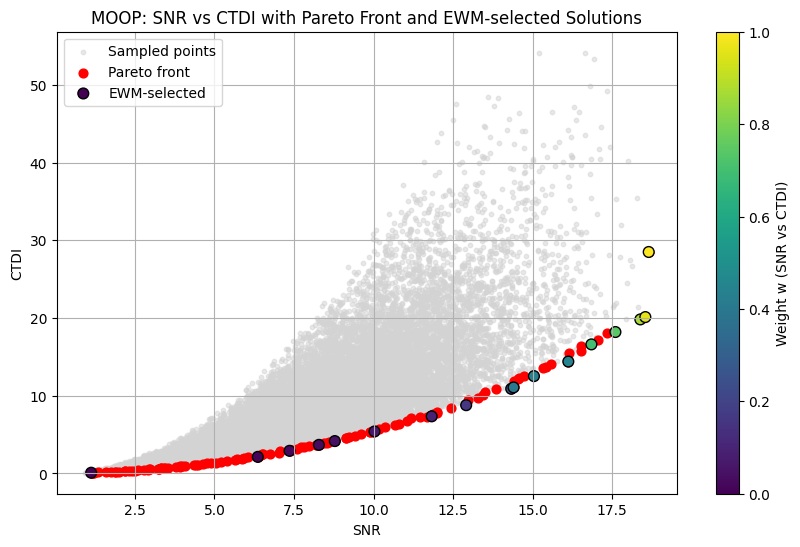

In [170]:

snr_vals = results["objectives"]["snr"]
ctdi_vals = results["objectives"]["ctdi"]

pareto_indices = results["pareto_indices"]

# Extract EWM-selected SNR and CTDI
ewm_snr = np.array([s['snr'] for s in selected_info])
ewm_ctdi = np.array([s['ctdi'] for s in selected_info])
ewm_weights = np.array([s['weight'] for s in selected_info])

# --- Plot ---
plt.figure(figsize=(10, 6))

# All sampled points (light gray)
plt.scatter(snr_vals, ctdi_vals, s=10, color='lightgray', alpha=0.5, label='Sampled points')

# Pareto front points (red)
plt.scatter(snr_vals[pareto_indices], ctdi_vals[pareto_indices], s=40, color='red', label='Pareto front')

# EWM-selected solutions (blue, colored by weight)
scatter = plt.scatter(ewm_snr, ewm_ctdi, s=60, c=ewm_weights, cmap='viridis', edgecolor='black', label='EWM-selected')

# Colorbar for weights
cbar = plt.colorbar(scatter)
cbar.set_label('Weight w (SNR vs CTDI)')

# Labels and title
plt.xlabel('SNR')
plt.ylabel('CTDI')
plt.title('MOOP: SNR vs CTDI with Pareto Front and EWM-selected Solutions')
plt.legend()
plt.grid(True)
plt.show()
